In [3]:
import pickle
import analysis_config
from dynamics_sims import plot_flow_field_utils
from online_analysis import generate_models
import math
%matplotlib notebook

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 13:29:28.792522. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 13:29:29.406300. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



(21, 21)
(3, 21)


<IPython.core.display.Javascript object>


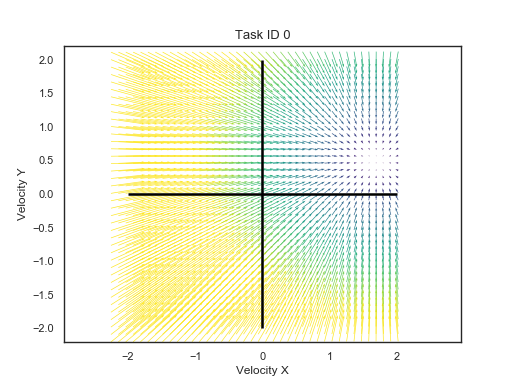

(21, 21)
(3, 21)


<IPython.core.display.Javascript object>


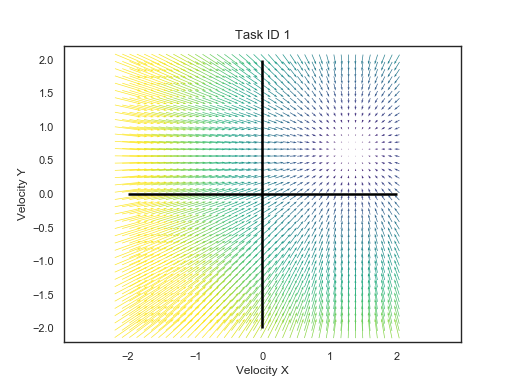

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 15:20:50.061635. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [34]:
### Task specific 
dat = pickle.load(open(analysis_config.config['jeev_pref'] + 'tuning_models_jeev_model_set7_task_spec_pls_gen.pkl', 'rb'))

### Construct A matrix from model in dat; 
day = 1; 
model_nm = 'hist_1pos_0psh_0spksm_1_spksp_0'
i_fold = 0; 
n_folds = 5; 

### Just CO task for now 
for task in range(2):

    key = i_fold + n_folds*(task)

    model = dat[day, model_nm, key, task, 'model']
    plot_potent_dyn(model, title = 'Task ID %d'%task, animal='jeev')

(21, 21)
(3, 21)


<IPython.core.display.Javascript object>


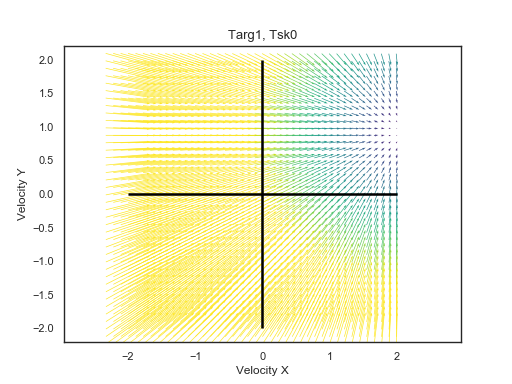

(21, 21)
(3, 21)


<IPython.core.display.Javascript object>


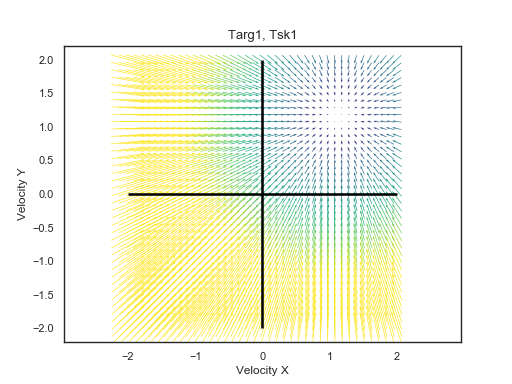

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 15:20:17.729061. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [33]:
### Condition specific 
dat = pickle.load(open(analysis_config.config['jeev_pref'] + 'tuning_models_jeev_model_set7_cond_spec.pkl', 'rb'))

### Construct A matrix from model in dat; 
day = 0; 
model_nm = 'hist_1pos_0psh_0spksm_1_spksp_0'
i_fold = 0; 
n_folds = 5; 
for targ in range(1, 2):
    
    ### Just CO task for now 
    for task in range(2):
        
        key = i_fold + n_folds*(task*10 + targ)
        key2 = (task*10 + targ)
        model = dat[day, model_nm, key, key2, 'model']
        plot_potent_dyn(model, title = 'Targ%d, Tsk%d'%(targ, task), animal='jeev')

In [7]:
def model_2_Amat(mod):
    ''' Add intercept onto the end and bottom; '''
    A = np.hstack(( mod.coef_, mod.intercept_[:, np.newaxis] ))
    _, n = A.shape
    A = np.vstack((A, np.hstack(( np.zeros((n-1, )), [1] )) ))
    return A

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 13:32:48.096382. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [8]:
def kg_2_orth(KG_potent):
    _, n = KG_potent.shape
    KG_potent = np.vstack(( np.hstack((KG_potent, np.zeros((2, 1)))), np.hstack(( np.zeros((n)), [1]))))
    return KG_potent

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 13:32:48.533432. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)



In [27]:
def plot_potent_dyn(model, cmax = 2., scale = 5.5, width = 0.01, lims = 2,
                   title = '', animal = 'grom'):
    
    ### Add offsets to A
    A = model_2_Amat(model)
    print A.shape
    ### Get the kalman gain #####
    if animal == 'grom':
        KG_potent, KG_null_proj, KG_potent_orth = generate_models.get_KG_decoder_grom(day)
    elif animal == 'jeev':
        KG_potent, KG_null_proj, KG_potent_orth = generate_models.get_KG_decoder_jeev(day)
    
    KG_potent = kg_2_orth(KG_potent)
    U, S, Vh = scipy.linalg.svd(KG_potent); #[2x2, 2, nxn]
    
    ### Test reconstruction of KG_potent
    reconst = np.dot(U, np.dot(np.diag(S), Vh[:3, :]))
    np.allclose(KG_potent, reconst)
    
    #### Potent projection is Vh; 
    Neur2Vel = np.dot(U, Vh[:3, :])
    assert(np.allclose(np.linalg.norm(Neur2Vel, axis=1), 1.))
    assert(np.allclose(np.dot(Neur2Vel[0, :], Neur2Vel[1, :]), 0.))
    assert(np.allclose(np.dot(Neur2Vel[1, :], Neur2Vel[2, :]), 0.))
    print KG_potent.shape
    ### Make modified KG: 
    KGA = np.dot(Neur2Vel, np.dot(A, Neur2Vel.T))
    
    ### Plot the dynamics; 
    f, ax = plt.subplots()
    ax.axis('equal')
    lims = 2; 
    plot_flow_field_utils.plot_flow(KGA, ax, cmax = cmax, scale = scale, 
                                    width = width, xmin=-lims, xmax=lims, ymin=-lims,
                                   ymax = lims, dim0=0, dim1=1, nb_points = 40, setdimeq1 = True)
    ax.set_xlabel('Velocity X')
    ax.set_ylabel('Velocity Y')
    ax.vlines(0, -lims, lims, 'k')
    ax.hlines(0, -lims, lims, 'k')
    ax.set_title(title)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2020-05-20 15:14:14.107354. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)

